In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import dateutil.parser as parser
from datetime import datetime, date, timedelta
import torch
import skorch
import scipy
import torch.nn as nn
import torch
import torch.nn.functional as F
import sys
from skorch.helper import DataFrameTransformer
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from skorch.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from skorch import NeuralNetRegressor
import pickle

def identity_tokenizer(text):
    return text
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)

In [2]:
merged = pd.read_csv('mergedfullwithmoredates.csv')
from sklearn.model_selection import train_test_split  
mergedbig, mergedsmall = train_test_split(merged, test_size=0.15, random_state=0)
# mergedsmall.to_csv("mergedsmall.csv", index = False)
# mergedsmall = pd.read_csv('mergedsmall.csv')
merged = mergedsmall
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
# Obtaining the tweet contents into a list
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()
import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
merged

,text,referenced_tweets,id,lang,Date,time,usedate,usedate1,usedate2,usedate3,...,Volume,Open,High,Low,Change,Change1,Change2,Change3,Change4,Change5
1147845,2020 is almost ended\n\nBRAND NEW SEALED FACTO...,1.317031e+18,1317047077411737601,en,2020-10-16,10:17:47,2020-10-16,2020-10-19,2020-10-20,2020-10-21,...,115393800.0,121.2800,121.5480,118.810,-2.260,-3.980,1.31,0.20,-1.7000,-1.3500
2318305,If you feel like Apple has no love for you by ...,NaN,1361013406829060106,en,2021-02-14,18:04:17,2021-02-16,2021-02-17,2021-02-18,2021-02-19,...,80576320.0,135.4900,136.0100,132.790,-2.300,-0.410,0.51,-0.37,-2.0100,2.1000
2772897,"📢NEW RIP IS LIVE📢\n\n2W1B 051 - iPhone, Capita...",NaN,1318150624626790402,en,2020-10-19,11:22:53,2020-10-19,2020-10-20,2020-10-21,2020-10-22,...,120639300.0,119.9600,120.4190,115.660,-3.980,1.310,0.20,-1.70,-1.3500,1.0400
1952614,#Apple has introduced a new #macOS version of ...,1.272588e+18,1272595399673630722,en,2020-06-15,18:22:41,2020-06-15,2020-06-16,2020-06-17,2020-06-18,...,138808920.0,83.3125,86.4200,83.145,2.435,0.155,-0.89,0.08,-1.2287,1.8825
33341,Good Deal😍 #MacBookPro #AppleEvent #Apple\n\nN...,1.389114e+18,1389114470304305154,en,2021-05-03,07:07:52,2021-05-03,2021-05-04,2021-05-05,2021-05-06,...,75135100.0,132.0400,134.0700,131.830,0.500,-3.340,-1.10,1.85,-0.6400,-2.5600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169957,Foreign Exchange History: How it All Started?\...,1.316240e+18,1316312507431051264,en,2020-10-14,09:38:52,2020-10-14,2020-10-15,2020-10-16,2020-10-19,...,151062300.0,121.0000,123.0300,119.620,0.190,1.990,-2.26,-3.98,1.3100,0.2000
2531839,"Tropicana Apple Juice, 10 oz., 24 Count\n\nSta...",NaN,1339593079318200320,en,2020-12-17,15:27:33,2020-12-17,2020-12-18,2020-12-21,2020-12-22,...,94359810.0,128.9000,129.5800,128.045,-0.200,-2.305,3.21,0.27,-1.2000,0.6500
1305376,"""emotional conclusion to a dazzling series!""\n...",1.303296e+18,1307074421098766336,en,2020-09-18,21:50:00,2020-09-18,2020-09-21,2020-09-22,2020-09-23,...,287104900.0,110.4000,110.8800,106.090,-3.560,5.540,-0.87,-4.50,3.0500,3.8500
1266310,3％超上昇した銘柄\n4434 サーバーワークス\n4625 アトミクス\n6777 ...,1.311853e+18,1311853293589725184,ja,2020-10-02,02:19:32,2020-10-02,2020-10-05,2020-10-06,2020-10-07,...,144712000.0,112.8900,115.3700,112.220,0.130,2.590,-2.54,0.46,-1.2800,1.6900


In [26]:
print(merged.isna().sum())

text                      0
referenced_tweets    200519
id                        0
lang                      0
Date                      0
time                      0
usedate                   0
usedate1                  0
usedate2                  0
usedate3                  0
usedate4                  0
usedate5                  0
Close/Last                0
Volume                    0
Open                      0
High                      0
Low                       0
Change                    0
Change1                   0
Change2                   0
Change3                   0
Change4                   0
Change5                   0
dtype: int64


In [3]:
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    

    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))

    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    
#     processed_tweet = re.sub(r'http\S+', '', processed_tweet)
    
    
#     processed_tweet = re.sub(r'co\S+', '', processed_tweet) 
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
 
    # Remove single characters from the start
#     processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
 
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
 
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    

    
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    
    processed_tweet = lemming(processed_tweet)
    
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)

In [4]:
y = merged[['Change','Change1','Change2','Change3','Change4','Change5','usedate','usedate1','usedate2','usedate3','usedate4','usedate5']]
# X = df3
# X = df2
# X = df2array
X = processed_tweets
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [30]:

lists = ['Change','Change1','Change2','Change3','Change4','Change5']
for pred in range(len(lists)):
    y_train2 = y_train.iloc[:,pred]
    y_test2 = y_test.iloc[:,pred]
    y_train2 = y_train2.values.reshape(-1,1)
    y_test2 = y_test2.values.reshape(-1,1)
    y_train2 = y_train2.astype(np.float32)
    y_test2 = y_test2.astype(np.float32)
    in_dimension = 5766
    hid_dimension = 10
    out_dimension = 1


    class PoleNN(nn.Module):
        def __init__(self):
            super(PoleNN, self).__init__()
            self.fc1 = nn.Linear(in_dimension,hid_dimension)
            self.fc2 = nn.Linear(hid_dimension,out_dimension)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, X):
            hidden = self.fc1(X)
            hidden = self.sigmoid(hidden)
            output = self.fc2(hidden)
            return output

    from skorch import NeuralNetRegressor
    from sklearn.pipeline import Pipeline
    x_trainshape = 5766
    class RegressorModule(nn.Module):
        def __init__(
                self,
                num_units=10,
                nonlin=F.relu,
        ):
            super(RegressorModule, self).__init__()
            self.num_units = num_units
            self.nonlin = nonlin

            self.dense0 = nn.Linear(x_trainshape, num_units)
            self.nonlin = nonlin
            self.dense1 = nn.Linear(num_units, 10)
            self.output = nn.Linear(10, 1)

        def forward(self, X, **kwargs):
            X = self.nonlin(self.dense0(X))
            X = F.relu(self.dense1(X))
            X = self.output(X)
            return X

    pole_model = RegressorModule()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)

    net = NeuralNetRegressor(module=pole_model, max_epochs=10, lr=0.1, callbacks =[('earlystopping',EarlyStopping())])
    def typechange(x):
        return x.astype(dtype = np.float32)
    typetransform = FunctionTransformer(typechange)
    def inputneuron(x):
        x_trainshape = x.shape[1]
    #     return x_trainshape
    inputneuronnumber = FunctionTransformer(inputneuron)
    # pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
    # pipe = Pipeline([('net', net)])
    pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


    # net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
    pipe.fit(X=x_train, y=y_train2)
    y_pred = pipe.predict(x_test)
    rmse = mean_squared_error(y_test2, y_pred, squared = False)
    print(lists[pred], "RMSE:", rmse)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        4.1846        4.0698  73.8954
      2        4.0142        4.0060  74.4248
      3        3.9791        3.9769  74.2980
      4        3.9619        3.9632  74.2280
      5        3.9485        3.9586  74.2141
      6        3.9380        3.9538  73.5068
      7        3.9293        3.9553  74.4788
      8        3.9212        3.9790  73.9793
      9        3.9147        3.9785  73.1921
     10        3.9083        3.9682  74.5897
Change RMSE: 1.9920682
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.6476        3.4830  73.0193
      2        3.4972        3.5298  73.8824
      3        3.4652        3.5480  72.9294
      4        3.4475        3.4897  73.9084
      5        3.4372        3.4482  73.0073
      6        3.4294        3.4616  72.9793
      7        3.4234        3.4063  73.1971
      8        3.4179        3.4

[Text(0.5, 0, 'Days Ahead Modelled'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'Days Ahead Modelled Against RMSE')]

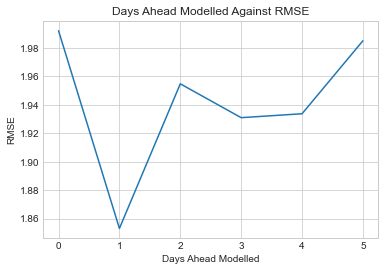

In [43]:
changelist = [1.9920682,1.8530582,1.9547465,1.9309403,1.9336934,1.9850181]
namelist = [0,1,2,3,4,5]
plt.style.use('seaborn-whitegrid')
ax = sns.lineplot(x=namelist,y=changelist)
ax.set(xlabel='Days Ahead Modelled',ylabel='RMSE',title='Days Ahead Modelled Against RMSE')

In [17]:
print((y_train['Change1'].isna().sum()))

352


In [ ]:
y_train2 = y_train['Change1']
y_test2 = y_test['Change1']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 5766
hid_dimension = 10
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 5766
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=200,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 200)
        self.output = nn.Linear(200, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=10, lr=0.1, callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)

In [38]:
modelpreds = y_pred
y = y_test2
z = y_test['usedate1']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
for uni in unique:
    predsum = 0
    reala = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            reala = real
    invested += abs(predsum)
    daychange = predsum * reala
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [34181.875]
Accuracy: 0.6234817813765182
Sum Invested: [18243.033]
Profitability: [1.8736948]


In [5]:
y_train2 = y_train['Change1']
y_test2 = y_test['Change1']
y_train2 = y_train2.values.reshape(-1,1)
y_test2 = y_test2.values.reshape(-1,1)
y_train2 = y_train2.astype(np.float32)
y_test2 = y_test2.astype(np.float32)
in_dimension = 5766
hid_dimension = 10
out_dimension = 1


class PoleNN(nn.Module):
    def __init__(self):
        super(PoleNN, self).__init__()
        self.fc1 = nn.Linear(in_dimension,hid_dimension)
        self.fc2 = nn.Linear(hid_dimension,out_dimension)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        hidden = self.fc1(X)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline
x_trainshape = 5766
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=200,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(x_trainshape, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 200)
        self.output = nn.Linear(200, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

pole_model = RegressorModule()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(pole_model.parameters(), lr = 0.1)
optimum_params = {'net__lr': 0.0015539382932245303, 'net__max_epochs': 20, 'net__optimizer__momentum': 0.9375124227337543}
net = NeuralNetRegressor(module=pole_model, max_epochs=optimum_params['net__max_epochs'], lr=optimum_params['net__lr'], optimizer__momentum=optimum_params['net__optimizer__momentum'], callbacks =[('earlystopping',EarlyStopping())])
def typechange(x):
    return x.astype(dtype = np.float32)
typetransform = FunctionTransformer(typechange)
def inputneuron(x):
    x_trainshape = x.shape[1]
#     return x_trainshape
inputneuronnumber = FunctionTransformer(inputneuron)
# pipe = Pipeline([('transform', DataFrameTransformer()),('net', net)])
# pipe = Pipeline([('net', net)])
pipe = Pipeline([("tfidf_vector_com", TfidfVectorizer(tokenizer=identity_tokenizer, input="array", lowercase=False, norm="l2", max_features=None, sublinear_tf=True,token_pattern=r'[^\s]+')), ("typetransform", typetransform), ("net", net)])


# net = skorch.NeuralNetClassifier(module=PoleNN, max_epochs=20, lr=0.1, criterion=torch.nn.NLLLoss)
pipe.fit(X=x_train, y=y_train2)
y_pred = pipe.predict(x_test)
rmse = mean_squared_error(y_test2, y_pred, squared = False)
print("RMSE:", rmse)


  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        3.6959        3.6629  104.1974
      2        3.6429        3.5530  111.0067
      3        3.5510        3.4918  109.5075
      4        3.5190        3.4723  107.7780
      5        3.4960        3.4485  108.6370
      6        3.4744        3.4412  109.4830
      7        3.4533        3.4211  111.7220
      8        3.4332        3.4093  112.4090
      9        3.4148        3.3908  102.1680
     10        3.3982        3.3823  106.2431
     11        3.3824        3.3725  104.4129
     12        3.3677        3.3656  104.4767
     13        3.3538        3.3609  101.5206
     14        3.3406        3.3658  107.0079
     15        3.3281        3.3661  104.5490
     16        3.3147        3.3721  103.9901
     17        3.3022        3.3707  103.6913
Stopping since valid_loss has not improved in the last 5 epochs.
RMSE: 1.8422937


In [6]:
modelpreds = y_pred
y = y_test2
z = y_test['usedate1']
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [735.8842]
Accuracy: 0.6882591093117408
Sum Invested: [380.18018]
Profitability: [1.9356196]


In [7]:
merged = pd.read_csv('mergedfullholdout.csv')
merged = merged.dropna(subset=['Change1','Change2','Change3','Change4','Change5'])
all_tweets = merged["text"]
all_tweets = all_tweets.to_list()

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
def lemming(tweet):
    a = word_tokenize(tweet)
    answer = list(map(lambda x: lemmatizer.lemmatize(x), a))
    return answer
from nltk.tokenize.treebank import TreebankWordDetokenizer
# https://python.gotrained.com/scraping-tweets-sentiment-analysis/
stop_words = set(stopwords.words('english'))
processed_tweets = []
X = all_tweets
for tweet in range(0, len(X)):  
    
    processed_tweet = re.sub(r"http\S+", "", str(X[tweet]))
    # Remove all the special characters
    processed_tweet = re.sub(r'\W', ' ', processed_tweet)
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    # Remove single characters from the start
    # Substituting multiple spaces with single space
    processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
    # Removing prefixed 'b'
    processed_tweet = re.sub(r'^b\s+', '', processed_tweet)
    processed_tweet = re.sub(r'of|to|has|keep|ll', '', processed_tweet)
    # Converting to Lowercase
    processed_tweet = processed_tweet.lower()
    processed_tweet = lemming(processed_tweet)
    processed_tweet = [word for word in processed_tweet if word not in stop_words]
    processed_tweet = TreebankWordDetokenizer().detokenize(processed_tweet)    
    
    # remove all single characters
    processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
    processed_tweets.append(processed_tweet)
x_holdout = processed_tweets
y_holdout = merged['Change1']
y_holdout_dates = merged['usedate1']
y_holdout = y_holdout.values.reshape(-1,1)
y_holdout = y_holdout.astype(np.float32)


In [10]:
y_pred_holdout= pipe.predict(x_holdout)
rmse = mean_squared_error(y_holdout, y_pred_holdout, squared = False)
print("RMSE:", rmse)

RMSE: 1.3798504


In [11]:
modelpreds = y_pred_holdout
y = y_holdout
z = y_holdout_dates
unique = z.unique()
profit = 0
bullorbearcount = 0
invested = 0
predsumlist = []
realalist = []
for uni in unique:
    predsum = 0
    reala = 0
    predcount = 0
    for i, (pred, real, date) in enumerate(zip(modelpreds, y, z)):
        if date == uni:
            predsum += pred
            predcount += 1
            reala = real
    predsum = (predsum/predcount)*14.77377722861989
    invested += abs(predsum)
    daychange = predsum * reala
    predsumlist.append(predsum)
    realalist.append(reala)
    profit += daychange
    if predsum > 0 and reala > 0:
        bullorbearcount += 1
    elif predsum < 0 and reala < 0:
        bullorbearcount += 1
print("Profit:", profit)
print("Accuracy:", (bullorbearcount/len(unique)))
print("Sum Invested:", invested)
print("Profitability:", (profit/invested))

Profit: [8.428209]
Accuracy: 0.5277777777777778
Sum Invested: [18.09796]
Profitability: [0.46569943]


In [12]:
predsuml = [item for sublist in predsumlist for item in sublist]
realal = [item for sublist in realalist for item in sublist]

In [53]:
print(min(unique))

2020-05-13


In [13]:
diction = {"Predictions": predsuml, "Real": realal, "Dates": unique}
dfsea = pd.DataFrame(diction) 
dfsea = dfsea.sort_values(by=['Dates'])
plt.style.use('seaborn-whitegrid')

([<matplotlib.axis.XTick at 0x2172fd59730>,
 [Text(0, 0, ''), Text(0, 0, '')])

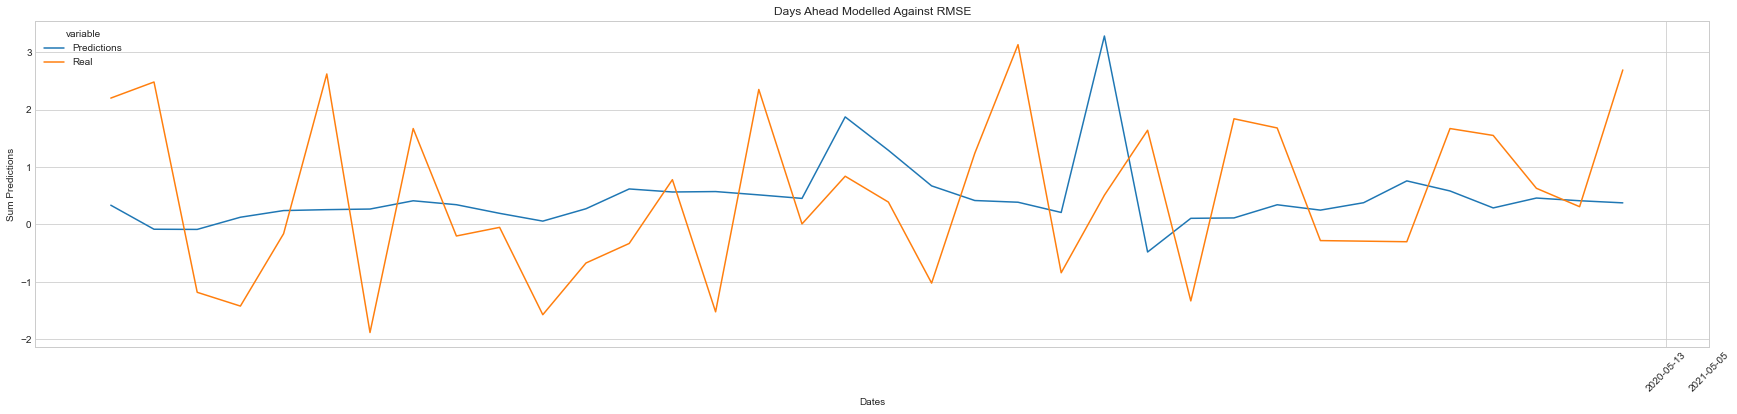

In [14]:
fig_dims = (30, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='Dates',y='value',hue='variable',ax=ax, data = pd.melt(dfsea,["Dates"]))
ax.set(xlabel='Dates',ylabel='Sum Predictions',title='Days Ahead Modelled Against RMSE')
plt.xticks(['2020-05-13','2021-05-05'],rotation=45)

In [41]:
predsumlabs = [abs(number) for number in predsuml]
realalabs = [abs(number) for number in realal]
print(sum(predsumlabs)/len(predsumlabs))
print(sum(realalabs)/len(realalabs))
print((sum(realalabs)/len(realalabs))/(sum(predsumlabs)/len(predsumlabs)))

0.10486829351374091
1.5493008067175325
14.77377722861989
